# Contribution of rivers to flux of Mn across boundaries

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
from itertools import compress
import datetime as dt
# import seaborn as sns; sns.set()
import os
import cmocean
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax-imin
jsize = jmax-jmin

# model result set:
folder_ref  = '/data/brogalla/run_storage/Mn-reference-202110/'
folder_glac = '/data/brogalla/run_storage/river-glacial-202112/'
folder_cont = '/data/brogalla/run_storage/river-continental-202112/'

# Colors:
color_glac_dark = '#05507d'
color_glac = '#0873b4'
color_cont = '#ab5c29'

In [3]:
years = [2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, \
         2016, 2017, 2018, 2019]

In [4]:
# Coordinates of boundaries:
xmin = imin+1; ymin=jmin+1
l2i = 1935-xmin; l2j = np.arange(450-ymin,530-ymin)  # Parry Channel western XS ##2
P1i = 1585-xmin; P1j = np.arange(485-ymin,538-ymin)  # Parry Channel eastern XS ##11
r1i = 1520-xmin; r1j = np.arange(505-ymin,673-ymin)  # Baffin Bay XS            ##8
t1i = np.arange(1635-xmin,1653-xmin); t1j = 760-ymin # Nares Strait northern XS ##7
N1i = np.arange(1570-xmin,1630-xmin); N1j = 635-ymin # Nares Strait southern XS ##10

#### Load files:

In [5]:
# ANHA12 grid:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
tmask      = np.array(mesh.variables['tmask'])[0,:,imin:imax,jmin:jmax]
land_mask  = np.ma.masked_where((tmask[:,:,:] > 0.1), tmask[:,:,:]) 
lons       = np.array(mesh.variables['nav_lon'])
lats       = np.array(mesh.variables['nav_lat'])
depths     = np.array(mesh.variables['gdept_1d'])[0,:]
e1t_base   = np.array(mesh.variables['e1t'])[0,imin:imax,jmin:jmax]
e2t_base   = np.array(mesh.variables['e2t'])[0,imin:imax,jmin:jmax]
e3t        = np.array(mesh.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask[:,:,:] < 0.1), e3t)

#### Functions:

In [6]:
def time_series_pickle(experiment, year):
    folder = '/ocean/brogalla/GEOTRACES/time-series/'
    
    # --- Coordinates of boundaries ---
    # Parry Channel western XS -- 2
    # Parry Channel eastern XS -- 11
    # Baffin Bay XS            -- 8
    # Nares Strait northern XS -- 7
    # Nares Strait southern XS -- 10
    
    # Load calculated time series of fluxes:
    time_series_V1, time_series_V2, time_series_V3, time_series_V4, time_series_V5, time_series_V6,time_series_V7,\
    time_series_V8, time_series_V9, time_series_V10, time_series_V11, time_series_mn1, time_series_mn2, \
    time_series_mn3, time_series_mn4, time_series_mn5, time_series_mn6, time_series_mn7, time_series_mn8, \
    time_series_mn9, time_series_mn10, time_series_mn11 = \
        pickle.load(open(f'{folder}{experiment}/time-series-{year}.pickle','rb'))  

    # convert mn from mol m3/L s --> mol /s by multiplying by 1e3
    return time_series_mn2*1e3, time_series_mn11*1e3, time_series_mn8*1e3, time_series_mn7*1e3, time_series_mn10*1e3

In [7]:
def file_dates(year):
    #start_date and end_date are datetime objects
    start_date = dt.datetime(year,1,1)
    end_date   = dt.datetime(year,12,31)
    
    file_list1 = np.sort(os.listdir(f'{folder_ref}ANHA12_ref-{year}_20211012/'))
    file_list2 = np.sort(os.listdir('/data/brogalla/ANHA12/'))
    
    Vlist = [i[26:31]=='gridV' for i in file_list2]
    gridV_list = list(compress(file_list2, Vlist))
    dateV_list = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_list]
    gridV_file_list = list(compress(gridV_list, [V > start_date and V < end_date for V in dateV_list]))
    
    dates = [dt.datetime.strptime(i[14:25], "y%Ym%md%d") for i in gridV_file_list]
    
    return dates

#### Calculations:

In [8]:
ref_PCW  = np.empty((len(years),72,50,79)); ref_PCE  = np.empty((len(years),72,50,52)); # reference experiment
glac_PCW = np.empty((len(years),72,50,79)); glac_PCE = np.empty((len(years),72,50,52)); # glacial-enhanced experiment
cont_PCW = np.empty((len(years),72,50,79)); cont_PCE = np.empty((len(years),72,50,52)); # continental-enhanced experiment

ref_NSN  = np.empty((len(years),72,50,17)); ref_NSS  = np.empty((len(years),72,50,59)); 
glac_NSN = np.empty((len(years),72,50,17)); glac_NSS = np.empty((len(years),72,50,59)); 
cont_NSN = np.empty((len(years),72,50,17)); cont_NSS = np.empty((len(years),72,50,59)); 

ref_BB   = np.empty((len(years),72,50,167)) 
glac_BB  = np.empty((len(years),72,50,167))
cont_BB  = np.empty((len(years),72,50,167))

for i, year in enumerate(years):
    yref_PCW,  yref_PCE,  yref_BB,  yref_NSN,  yref_NSS  = time_series_pickle('Mn-reference-202110'     , year)
    yglac_PCW, yglac_PCE, yglac_BB, yglac_NSN, yglac_NSS = time_series_pickle('river-glacial-202112'    , year)
    ycont_PCW, ycont_PCE, ycont_BB, ycont_NSN, ycont_NSS = time_series_pickle('river-continental-202112', year)
    
    ref_PCW[i,:,:,:]  = yref_PCW;  ref_PCE[i,:,:,:]  = yref_PCE;
    glac_PCW[i,:,:,:] = yglac_PCW; glac_PCE[i,:,:,:] = yglac_PCE;
    cont_PCW[i,:,:,:] = ycont_PCW; cont_PCE[i,:,:,:] = ycont_PCE;
    
    ref_BB[i,:,:,:]   = yref_BB
    glac_BB[i,:,:,:]  = yglac_BB
    cont_BB[i,:,:,:]  = ycont_BB
    
    ref_NSN[i,:,:,:]  = yref_NSN;  ref_NSS[i,:,:,:]  = yref_NSS;
    glac_NSN[i,:,:,:] = yglac_NSN; glac_NSS[i,:,:,:] = yglac_NSS;
    cont_NSN[i,:,:,:] = ycont_NSN; cont_NSS[i,:,:,:] = ycont_NSS;

In [9]:
dates = np.array([])
for year in range(2002, 2020):
    dates = np.append(dates, file_dates(year))

In [10]:
print(ref_PCW.shape) # year, 5 day, depth, grid points --- Mn is in mol/s for each grid point

(18, 72, 50, 79)


In [11]:
def proportion_above_ref(ref_flux, exp_flux):
    # Shape of input arrays of Mn fluxes: (years, 5-day, depths, grid points)
    
    sum_ref = np.sum(ref_flux, axis=(2,3)).flatten()
    sum_exp = np.sum(exp_flux, axis=(2,3)).flatten()
              
    cumsum_ref = np.cumsum(np.sum(ref_flux, axis=(2,3))).flatten()
    cumsum_exp = np.cumsum(np.sum(exp_flux, axis=(2,3))).flatten()
              
    cumsum_proportion_above = (1-np.divide(cumsum_exp, cumsum_ref))*100*2
    sum_proportion_above    = (1-np.divide(sum_exp, sum_ref))*100*2
    
    return cumsum_proportion_above, sum_proportion_above

In [12]:
# Nares Strait:
NSS_glacial_cumsum, NSS_glacial_sum         = proportion_above_ref(ref_NSS, glac_NSS)
NSN_glacial_cumsum, NSN_glacial_sum         = proportion_above_ref(ref_NSN, glac_NSN)
NSS_continental_cumsum, NSS_continental_sum = proportion_above_ref(ref_NSS, cont_NSS)
NSN_continental_cumsum, NSN_continental_sum = proportion_above_ref(ref_NSN, cont_NSN)

# Baffin Bay:
BB_glacial_cumsum, BB_glacial_sum           = proportion_above_ref(ref_BB, glac_BB)
BB_continental_cumsum, BB_continental_sum   = proportion_above_ref(ref_BB, cont_BB)

# Parry Channel:
PCW_glacial_cumsum, PCW_glacial_sum         = proportion_above_ref(ref_PCW, glac_PCW)
PCE_glacial_cumsum, PCE_glacial_sum         = proportion_above_ref(ref_PCE, glac_PCE)
PCW_continental_cumsum, PCW_continental_sum = proportion_above_ref(ref_PCW, cont_PCW)
PCE_continental_cumsum, PCE_continental_sum = proportion_above_ref(ref_PCE, cont_PCE)

### Figures

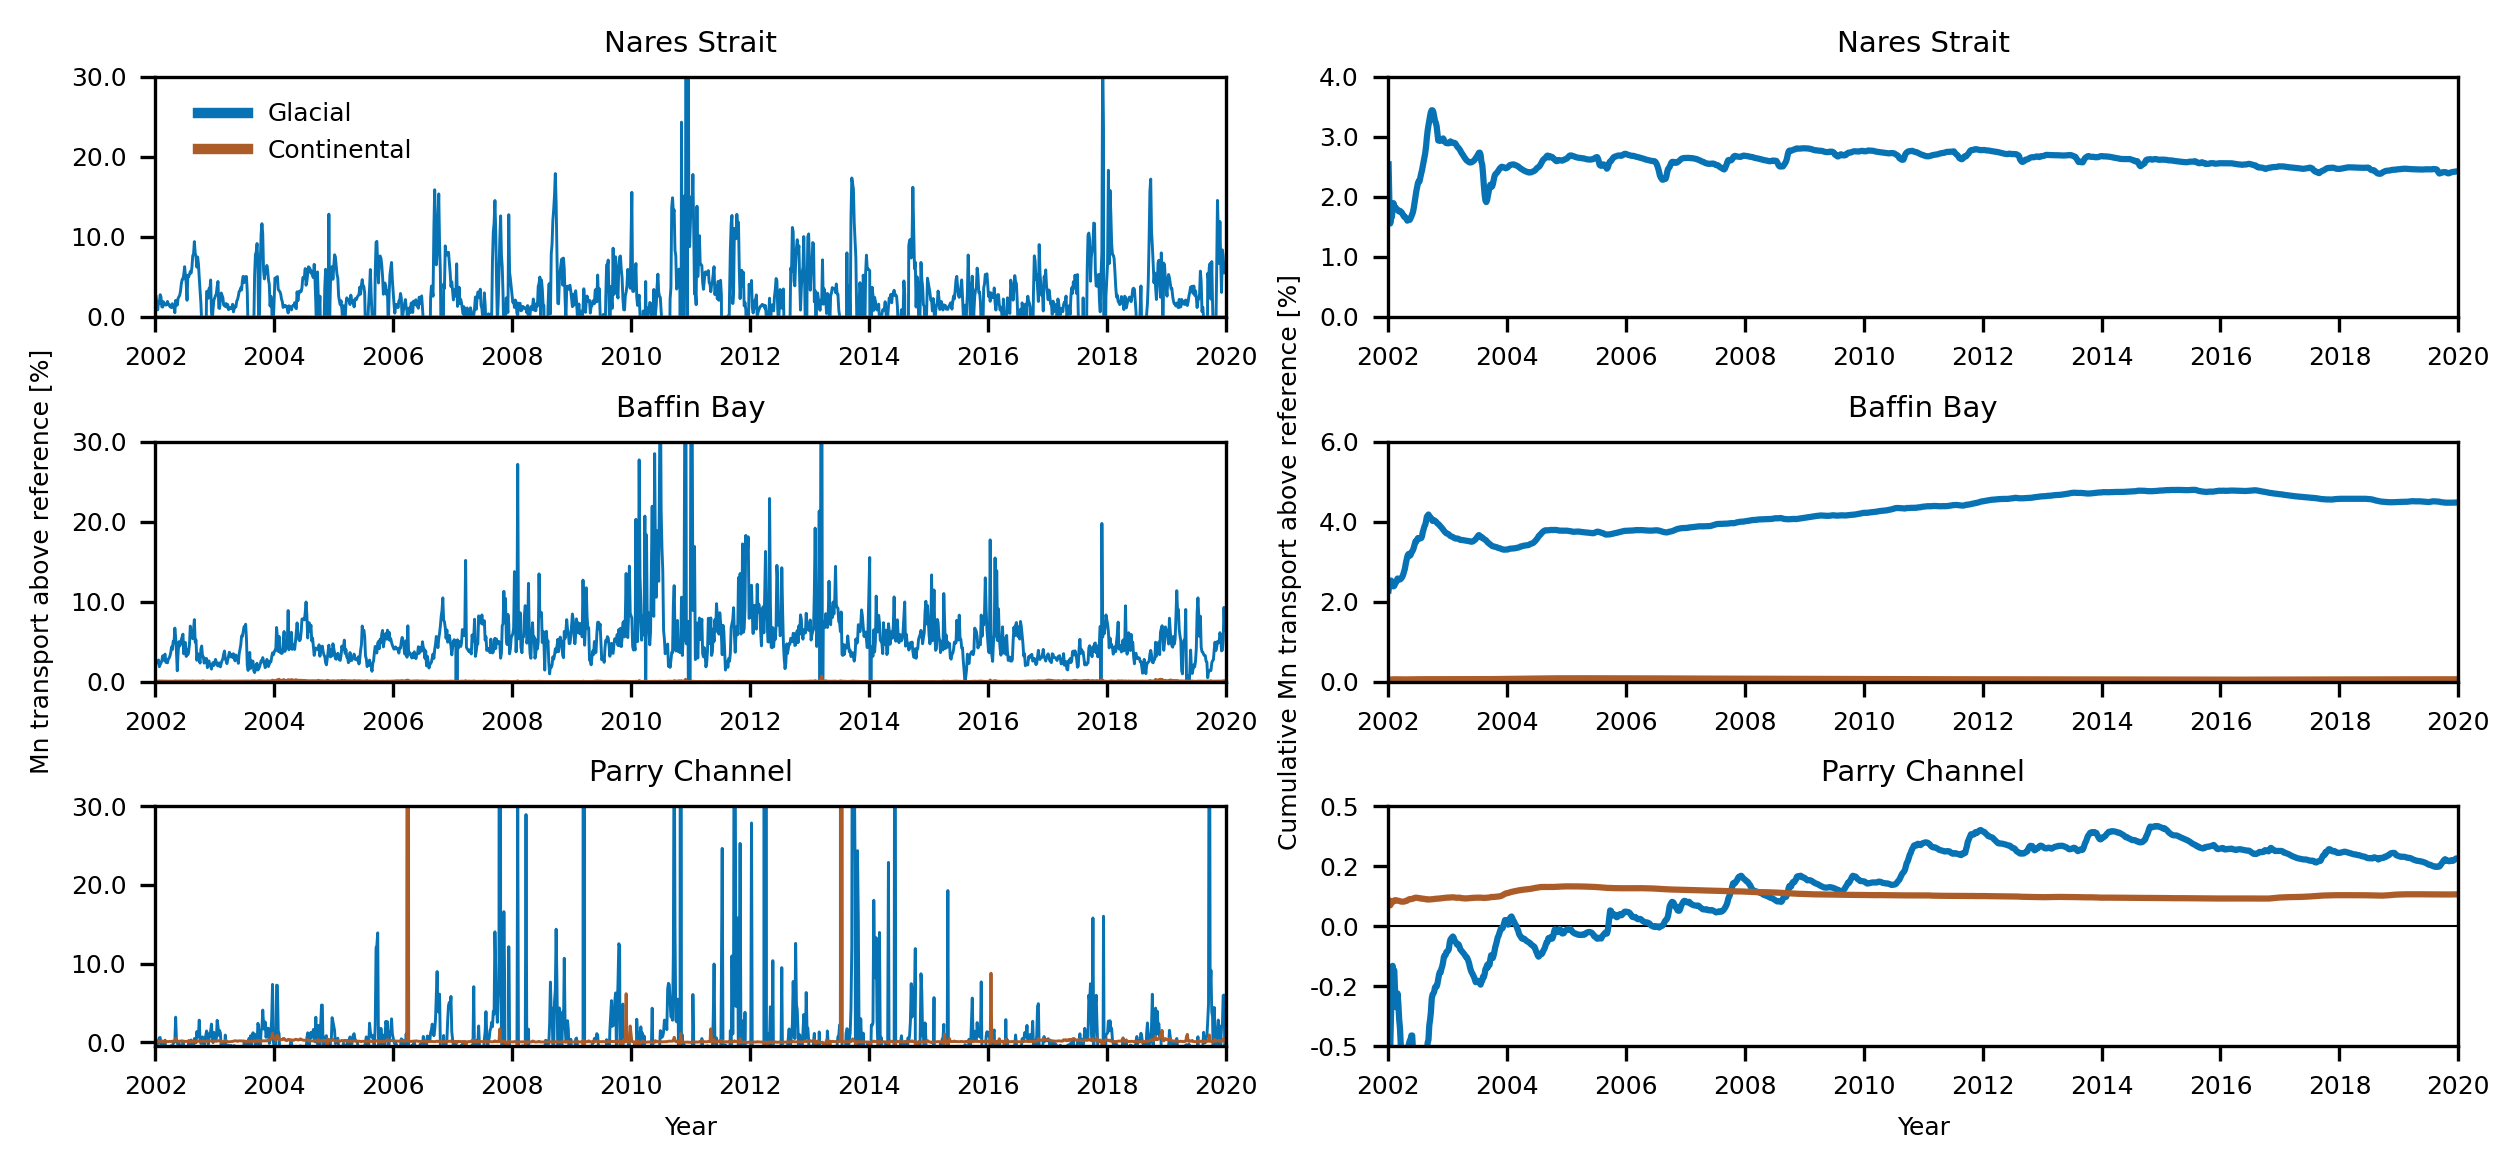

In [36]:
fig, ax = plt.subplots(3,2, figsize=(8.5,4), dpi=300)

#----------- General settings ------------------
ax[2,0].set_xlabel('Year', fontsize=6)
ax[2,1].set_xlabel('Year', fontsize=6)
ax[1,0].set_ylabel('Mn transport above reference [%]', fontsize=6)
ax[1,1].set_ylabel('Cumulative Mn transport above reference [%]', fontsize=6)

for axis in ax.ravel():
    axis.tick_params(axis='both', which='major', labelsize=6)
    axis.set_xlim(dt.datetime(2002,1,1),dt.datetime(2020,1,1))
    axis.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))


#----------- Nares Strait ----------------------
ax[0,0].set_title('Nares Strait', fontsize=7)
ax[0,0].set_ylim(0,30)
ax[0,0].plot(dates, -1*NSS_glacial_sum    , linewidth=0.7, color=color_glac)
ax[0,0].plot(dates, -1*NSS_continental_sum, linewidth=0.7, color=color_cont)
ax[0,0].plot([0,0], [0,0], linewidth=2.5, color=color_glac, label='Glacial')
ax[0,0].plot([0,0], [0,0], linewidth=2.5, color=color_cont, label='Continental')
ax[0,0].legend(loc=(0.03, 0.60), frameon=False, framealpha=0.5, fontsize=6)

ax[0,1].set_title('Nares Strait', fontsize=7)
ax[0,1].set_ylim(0, 4)
ax[0,1].plot(dates, -1*NSS_glacial_cumsum , linewidth=1.5, color=color_glac)

#----------- Baffin Bay ------------------------
ax[1,0].set_title('Baffin Bay', fontsize=7)
ax[1,0].set_ylim(0,30)
ax[1,0].plot(dates, -1*BB_glacial_sum    , linewidth=0.7, color=color_glac)
ax[1,0].plot(dates, -1*BB_continental_sum, linewidth=0.7, color=color_cont)

ax[1,1].set_title('Baffin Bay', fontsize=7)
ax[1,1].set_ylim(0, 6)
ax[1,1].plot(dates, -1*BB_continental_cumsum , linewidth=1.5, color=color_cont)
ax[1,1].plot(dates, -1*BB_glacial_cumsum , linewidth=1.5, color=color_glac)

#----------- Parry Channel ---------------------
ax[2,0].set_title('Parry Channel', fontsize=7)
ax[2,0].set_ylim(-0.5,30)
ax[2,0].plot(dates, PCE_glacial_sum       , linewidth=0.7, color=color_glac)
ax[2,0].plot(dates, -1*PCE_continental_sum, linewidth=0.7, color=color_cont)

ax[2,1].set_title('Parry Channel', fontsize=7)
ax[2,1].set_ylim(-0.5, 0.5)
ax[2,1].plot([dates[0], dates[-1]],[0, 0], linewidth=0.5, color='k')
ax[2,1].plot(dates, PCE_glacial_cumsum , linewidth=1.5, color=color_glac)
ax[2,1].plot(dates, -1*PCE_continental_cumsum , linewidth=1.5, color=color_cont)

plt.tight_layout(w_pad=0.5, h_pad=-2)

fig.savefig('/ocean/brogalla/GEOTRACES/figures/rivers/R4-time-series.png', bbox_inches='tight', dpi=300)

What about if instead of providing time series, we calculate the cumulative proportion contribution:

In [ ]:
print('Into Parry Channel: ')
print(f'Clean-ref:  {-100*(np.nansum(Parry_nosed_in)-np.nansum(Parry_ref_in))/np.nansum(Parry_ref_in):.2f}')
print(f'Rivers-ref: {100*(np.nansum(Parry_rivers_in)-np.nansum(Parry_ref_in))/np.nansum(Parry_ref_in):.2f}')
print('Out of Parry Channel: ')
print(f'Clean-ref:  {-100*(np.nansum(Parry_nosed_out)-np.nansum(Parry_ref_out))/np.nansum(Parry_ref_out):.2f}')
print(f'Rivers-ref: {100*(np.nansum(Parry_rivers_out)-np.nansum(Parry_ref_out))/np.nansum(Parry_ref_out):.2f}')

In [ ]:
print('Into Parry Channel: ')
print(f'Clean-ref:  {-100*(np.nansum(Parry_nosed_in)-np.nansum(Parry_ref_in))/np.nansum(Parry_ref_in):.2f}')
print(f'Rivers-ref: {100*(np.nansum(Parry_rivers_in)-np.nansum(Parry_ref_in))/np.nansum(Parry_ref_in):.2f}')
print('Out of Parry Channel: ')
print(f'Clean-ref:  {-100*(np.v(Parry_nosed_out)-np.v(Parry_ref_out))/np.v(Parry_ref_out):.2f}')
print(f'Rivers-ref: {100*(np.nansum(Parry_rivers_out)-np.nansum(Parry_ref_out))/np.nansum(Parry_ref_out):.2f}')